In [2]:
import librosa
import numpy as np

# Load './dummy.wav'
data, sr = librosa.load('./dummy.wav', sr=16000)
print(data.shape, sr)

# Extract only the high frequency magnitude part
data_hf = np.abs(librosa.stft(data, n_fft=1024, hop_length=256, win_length=1024, window='hann', center=True, pad_mode='reflect'))
print(data_hf.shape)



(749726,) 16000
(513, 2929)


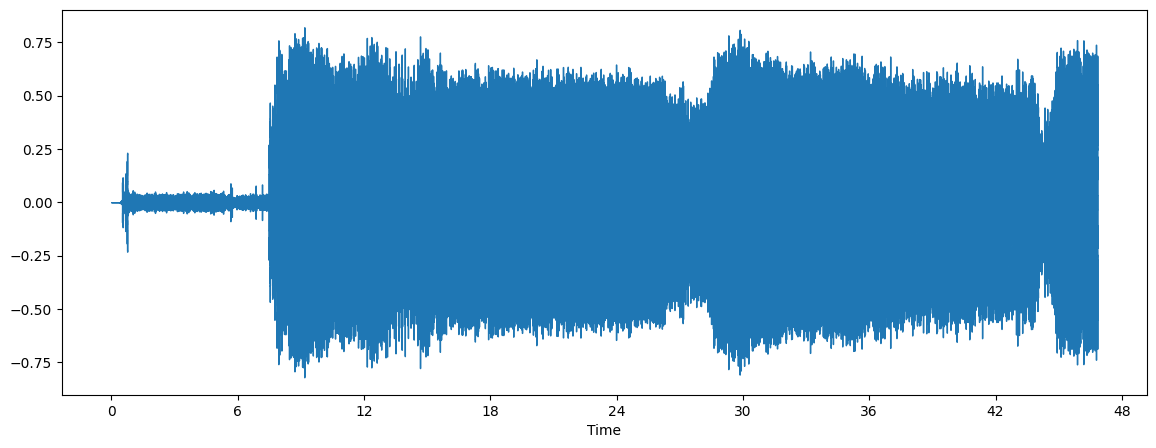

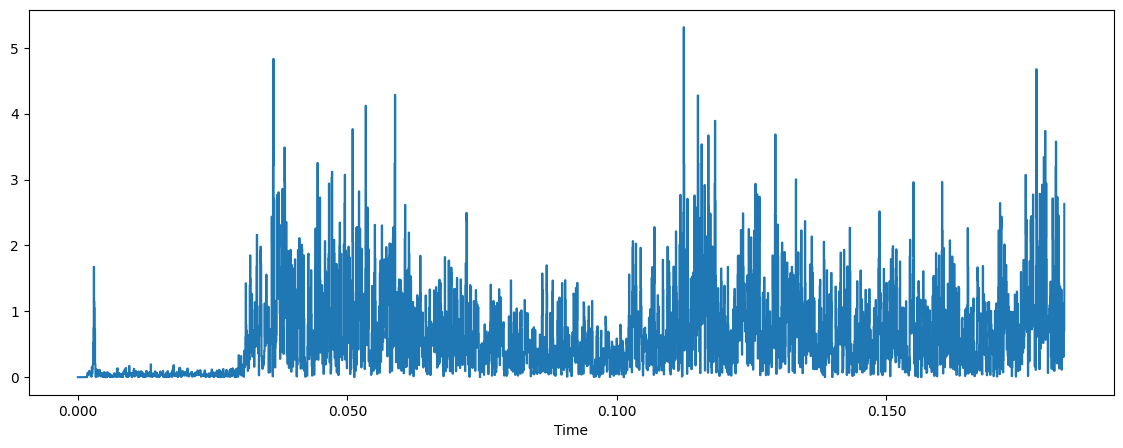

In [3]:
import matplotlib.pyplot as plt
import librosa.display

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(data, sr=sr)

# Plot the denoised waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(data_hf, sr=sr)

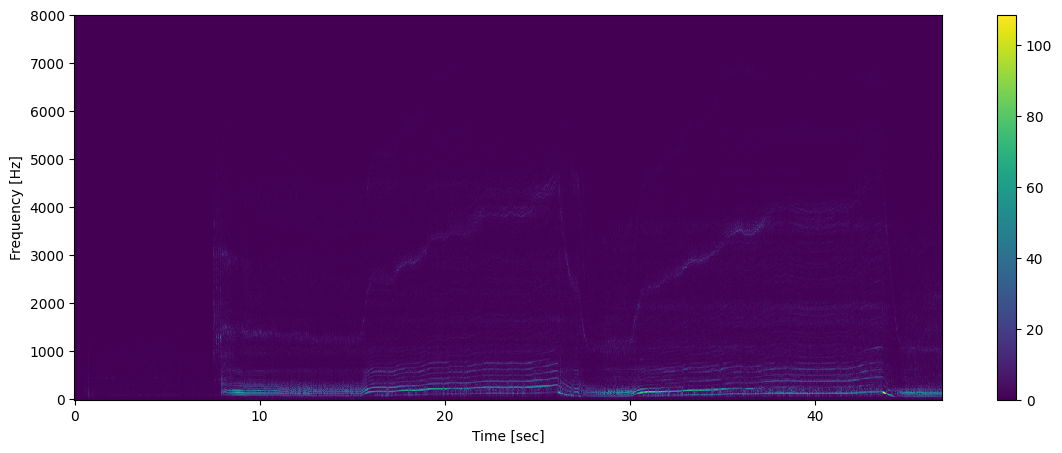

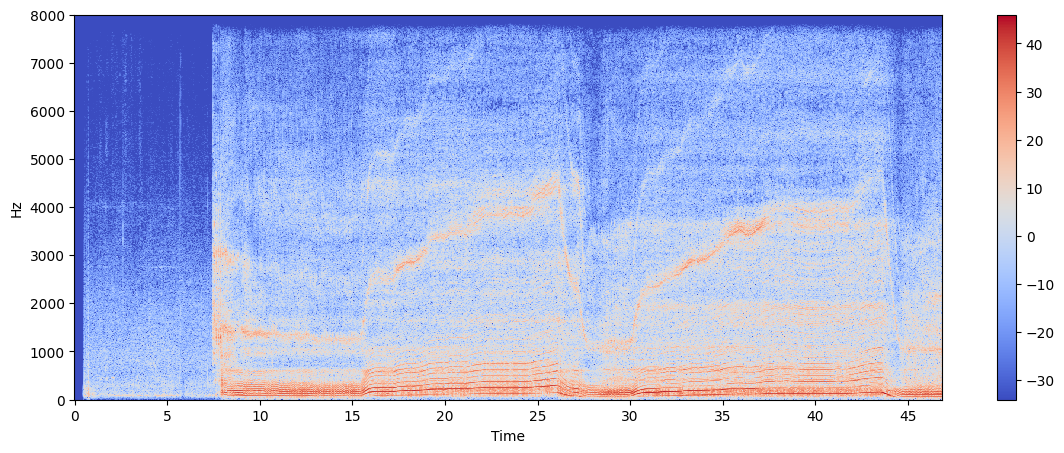

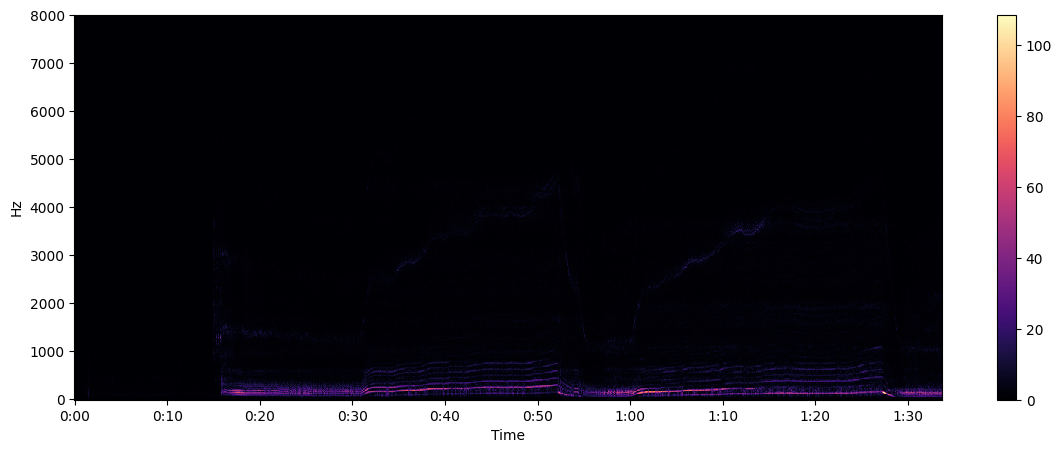

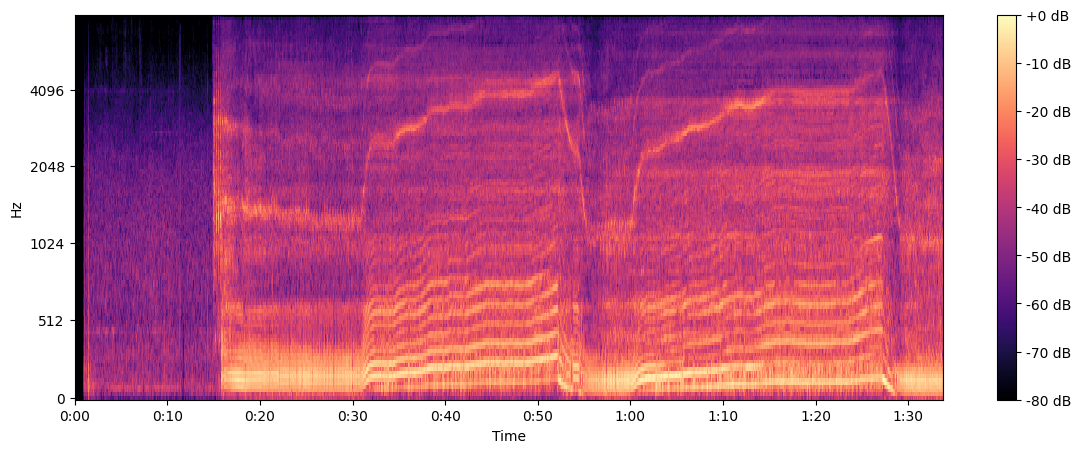

In [12]:
def tvdft(data, sr, n_fft=1024, hop_length=256, win_length=1024, window='hann', center=True, pad_mode='reflect'):
    # Compute the STFT
    X = librosa.stft(data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    # Compute the magnitude
    X_mag = np.abs(X)
    # Compute the phase
    X_phase = np.angle(X)
    # Compute the frequency
    freq = np.linspace(0, sr/2, X_mag.shape[0])
    # Compute the time
    time = np.linspace(0, data.shape[0]/sr, X_mag.shape[1])
    return X_mag, X_phase, freq, time

# Plot TVDFT
X_mag, X_phase, freq, time = tvdft(data, sr)
plt.figure(figsize=(14, 5))
plt.pcolormesh(time, freq, X_mag)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()



X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))

# Plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

# Plot the denoised spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(data_hf, sr=sr, x_axis='time', y_axis='hz', fmax=2000)
plt.colorbar()

# Plot the mel-spectrogram, only the frequency with the highest energy is shown
S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000, hop_length=256, win_length=1024, window='hann', center=True, pad_mode='reflect')
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')



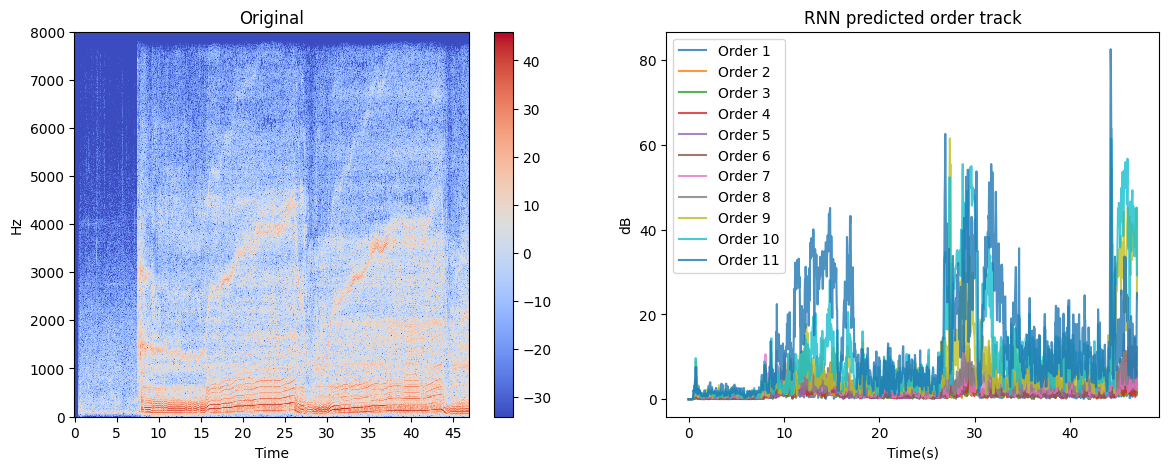

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

In [11]:
"""
TOT is realized by: 
Extracting a component from the raw signal that is closely connected to the shaft rotating
Sampling the signal in equal-angle increment according to the measured rotating speed
Constructing a shaft phase vs time map without integral
Using a time-varying filter and energy centrobaric correction method to execute TOT on high noise signal
Some TOT methods include: 
Generalized demodulation based tacho-less order tracking
Extended intrinsic chirp component decomposition for gears under large speed variation conditions
Spectral amplitude modulation for variable speed bearing fault diagnosis
STFTSC algorithm for rotor unbalance fault diagnosis under variable-speed conditions
"""

def tacholess_order_track(data, sr, n_fft=1024, hop_length=256, win_length=1024, window='hann', center=True, pad_mode='reflect'):
    """
    Tacholess order tracking
    """
    # Compute the STFT
    X = librosa.stft(data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    # Compute the magnitude
    X_mag = np.abs(X)
    # Compute the phase
    X_phase = np.angle(X)
    # Compute the frequency
    freq = np.linspace(0, sr/2, X_mag.shape[0])
    # Compute the time
    time = np.linspace(0, data.shape[0]/sr, X_mag.shape[1])
    return X_mag, X_phase, freq, time

# Vold-Kalman filter for Order tracking
def order_track(stft, num_order):
    """
    Vold-Kalman filter for Order tracking
    It takes in stft data, but returns the num_order dimensional arrays of amplitudes of the highest frequency component, starting from low to high
    """
    # Initialization
    # For each sweep of stft, we have num_order dimensional array of amplitudes and corresponding timestamp, starting from 0hz to 3000hz
    # we loop through each sweep and update the amplitude and timestamp if the amplitude and frequency is close to the previous one
    # if the amplitude is not close to the previous one, we add a new amplitude and timestamp to the array
    # we then return the array of amplitudes and timestamps

    # The first sweep
    stft = stft.T
    n = len(stft)

    # Initialization
    amp = np.zeros((n, num_order))
    freq = np.zeros((n, num_order))
    amp[0] = np.abs(stft[0, :num_order])
    freq[0] = np.angle(stft[0, :num_order])

    # Loop through each sweep
    for i in range(1, n):
        # Loop through each order
        for j in range(num_order):
            # Check if the amplitude and frequency is close to the previous one
            if np.abs(stft[i, j]) > 0.5 * np.abs(stft[i - 1, j]):
                amp[i, j] = np.abs(stft[i, j])
                freq[i, j] = np.angle(stft[i, j])
            else:
                amp[i, j] = amp[i - 1, j]
                freq[i, j] = freq[i - 1, j]

    return amp * np.exp(1j * freq)


def voldkalman(y, order, alpha=0.98):
    """
    Vold-Kalman filter for Order tracking
    """
    # Initialization
    y = y.reshape(-1, 1)
    n = len(y)
    x = np.zeros((n, order + 1), dtype = 'complex_')
    P = np.eye(order + 1) * 1e6
    R = np.eye(1) * 1e-6
    Q = np.eye(order + 1) * 1e-6

    # Filtering
    for i in range(n):
        x[i] = alpha * x[i - 1]
        P = alpha**2 * P + Q
        K = P @ np.linalg.inv(P + R)
        x[i] = x[i] + K @ (y[i] - x[i])
        P = (np.eye(order + 1) - K) @ P

    # Extract the highest frequency component
    x = x[:, -1]

    return x

X = librosa.stft(data)
X_order = order_track(X, 1)
# X_order = voldkalman(X_order, 1)
# Plot the spectrogram
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(abs(X)), sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Original')

# We assemble order 1,2,3,4,5 to form a 5 dimensional vector, and plot the order gram with the 5 dimensional vector
plt.subplot(1, 2, 2)
for i in range(1, 12):
    X_order = order_track(X, i)
    
    # If X_order is (1465, >1), set it to [0]
    if X_order.shape[1] > 1:
        X_order = X_order[:, -1]

    # Scale it to 0-47 seconds
    plot_x = np.linspace(0, 47, 1465)

    plt.plot(plot_x, np.abs(X_order), label=f'Order {i}', alpha=0.8)
    plt.xlabel('Time(s)')
    plt.ylabel('dB')
    # Legend
    plt.legend()
    # Title
    plt.title('RNN predicted order track')

plt.show()

# Plot the spectrogram
plt.figure(figsize=(14, 5))


In [23]:
def freqordermap(stft, sr, order_res, window='hann', center=True, pad_mode='reflect'):
    """
    Generate a spectral map of order versus frequency peak for order analysis
    """
    """
    The function freqordermap generates a spectral map of order versus frequency peak for order analysis. The approach removes smearing artifacts by resampling the signal at constant phase increments, producing a stationary sinusoid for each order. The resampled signal is analyzed using a short-time Fourier transform. Since each order is a fixed multiple of the reference rotational speed, an order map contains a straight order track as a function of RPM for each order.

    The function freqordermap accepts the same arguments as rpmfreqmap and also produces an interactive plot window when called with no output arguments. The resolution parameter is now specified in orders, rather than in Hz, and the spectral axis of the map is now order, rather than frequency. The function uses a flat-top window by default.

    Visualize the order map of the helicopter data using rpmordermap. Specify an order resolution of 0.005 orders.
    """

    # Initialization
    print(stft.shape)
    n = stft.shape[1]

    order = int(sr / 60)
    n_order = int(order / order_res)
    order_axis = np.linspace(0, order, n_order)
    order_map = np.zeros((n_order, n), dtype = 'complex_')

    # Filtering
    for i in range(n):
        order_map[:, i] = order_track(stft[:, i], n_order)

    return order_map, order_axis

# Visualization
X = np.abs(librosa.stft(data, n_fft=1024, hop_length=256, win_length=1024, window='hann', center=True, pad_mode='reflect'))
order_map, order_axis = freqordermap(X, sr, 0.005)

plt.figure(figsize=(14, 5))
librosa.display.specshow(librosa.amplitude_to_db(abs(order_map)), sr=sr, x_axis='time', y_axis='order', fmax=2000)
plt.colorbar()
plt.show()


(513, 2929)


MemoryError: Unable to allocate 2.32 GiB for an array with shape (53200, 2929) and data type complex128

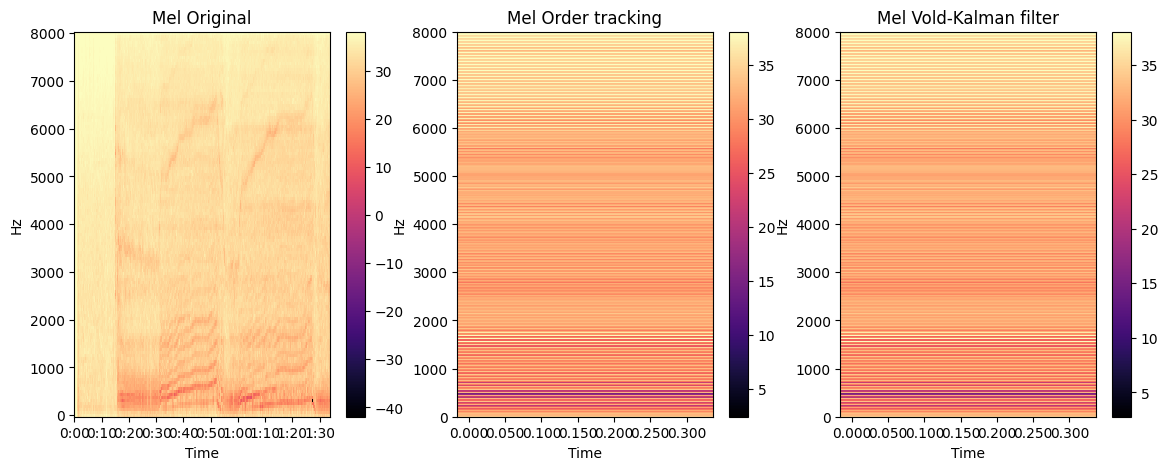

In [ ]:
# Plot denoised order tracking spectrogram
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(abs(S_dB)), sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Mel Original')


plt.subplot(1, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(abs(order_track(S_dB, 10))), sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Mel Order tracking')

plt.subplot(1, 3, 3)
librosa.display.specshow(librosa.amplitude_to_db(abs(voldkalman(S_dB, 10))), sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Mel Vold-Kalman filter')

plt.show()

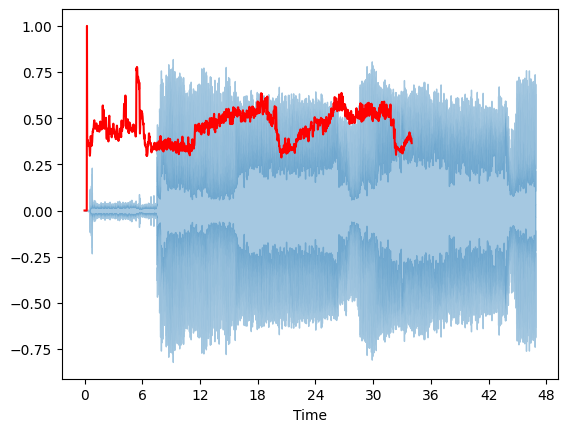

In [ ]:
# Feature Analysis, MFCC, e.g. Spectral Centroid
import sklearn
from sklearn import preprocessing
spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sr)[0]
spectral_centroids.shape

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(data, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()
